In [1]:

import requests
def hda_access(username, password, token_url='https://identity.data.destination-earth.eu/auth/realms/dedl/protocol/openid-connect/token'):

    username = username
    password = password
    access_token_response = requests.post(
    token_url,
    data = {'grant_type': 'password','scope' : 'openid', 'client_id' : 'hda-public', 'username' : username, 'password' : password},
    headers = {'Content-Type' : 'application/x-www-form-urlencoded'}
    )
    return access_token_response


username = 'miriam.mendez.serrano@estudiantat.upc.edu'
password = 'D2st3n1t34n21rth$'
access_token_response = hda_access(username, password)
access_token = access_token_response.json()['access_token']
print(access_token_response)

auth_headers = {"Authorization": f"Bearer {access_token}"}

 

<Response [200]>


In [ ]:
from tqdm import tqdm
import healpy as hp
import re
from datetime import date
from IPython.display import JSON
from dateutil.relativedelta import relativedelta
import tempfile
import pygrib
import numpy as np

# Initialize a list to store filenames
filenames = []

start_date = date(2020,8,1)
end_date = date(2020,8,31)

filters = {   
    key: {"eq": value}
    for key, value in {
        "class": "d1",             # fixed 
        "dataset": "climate-dt",   # fixed climate-dt access
        "activity": "ScenarioMIP", # activity + experiment + model (go together)
        "experiment": "SSP3-7.0",  # activity + experiment + model (go together)
        "model": "IFS-NEMO",       # activity + experiment + model (go together)
        "generation": "1",         # fixed Specifies the generation of the dataset, which can be incremented as required (latest is 1)
        "realization": "1",        # fixed Specifies the climate realization. Default 1. Based on perturbations of initial conditions
        "resolution": "high",      # standard/ high 
        "expver": "0001",          # fixed experiment version 
        "stream": "clte",          # fixed climate
        "time": "0000",            # choose the hourly slot(s)
        "type": "fc",              # fixed forecasted fields
        "levtype": "sfc",          # Surface fields (levtype=sfc), Height level fields (levtype=hl), Pressure level fields (levtype=pl), Model Level (Levtype=ml)
        "param": "175"    
    }.items()
}

current_date = start_date
# while current_date <= end_date:

#     last_date = current_date + relativedelta(months=1) - relativedelta(days=1)

range_start = current_date.strftime("%Y-%m-%dT00:00:00Z")
#     range_end = last_date.strftime("%Y-%m-%dT23:59:00Z")

response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
    "collections": ["EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION"],
    "bbox":[0.1, 40.5, 3.4, 42.9],
    "datetime": f"{range_start}",
    "query": filters
})
product = response.json()["features"][0]

# DownloadLink is an asset representing the whole product
download_url = product["assets"]["downloadLink"]["href"]
HTTP_SUCCESS_CODE = 200

direct_download_url = ''

response = requests.get(download_url, headers=auth_headers)
if (response.status_code == HTTP_SUCCESS_CODE):
    direct_download_url = product['assets']['downloadLink']['href']
else:
    JSON(response.json(), expanded=True)

# we poll as long as the data is not ready
if direct_download_url == '':
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        response = requests.get(url, headers=auth_headers, stream=True)
        response.raise_for_status()

# Check if Content-Disposition header is present
if "Content-Disposition" not in response.headers:
    print(response.headers)
    raise Exception("Content-Disposition header not found in response. Must be something wrong.")

total_size = int(response.headers.get("content-length", 0))

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
	data_stream = BytesIO()
	for chunk in response.iter_content(chunk_size=1024):
		data_stream.write(chunk)
    
data_stream.seek(0)
s3 = setup_S3("lumi")
bucket = "climate-dt"
filename = f"{str(current_date.year)}/{current_date.strftime('%Y%m%d')}_{'_'.join(map(str, bbox))}.grib"
s3.upload_fileobj(data_stream, bucket, filename)
print("Downloaded")

# print(f"downloading {range_start}")
# tempfile_path = tempfile.mktemp(suffix='.grib')
# with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
#     with open(tempfile_path, 'wb') as f:
#         for data in response.iter_content(1024):
#             progress_bar.update(len(data))
#             f.write(data)



# grbs = pygrib.open(tempfile_path)
# bbox = [0.1, 40.5, 3.4, 42.9]
# datechoice= current_date.strftime("%Y%m")
# filtered_filename = f"{datechoice}_{bbox[3]}_{bbox[0]}_{bbox[1]}_{bbox[2]}.grib"

# with open(filtered_filename, 'wb') as output_file:
#     for grb in grbs:

#         if 'healpix' in grb.typeOfGrid:
#             values = grb.values
#             nside = hp.npix2nside(len(values))
#             pixels = np.arange(len(values))

#             lons, lats = hp.pix2ang(nside, pixels, lonlat=True)
#             mask = (lons >= bbox[0]) & (lons <= bbox[2]) & (lats >= bbox[1]) & (lats <= bbox[3])
#             filtered_values = values[mask]

#             output_file.write(grb.tostring())
#         else:
#             # Write the original message if it's not HEALPix
#             output_file.write(grb.tostring())

# print(f"Filtered GRIB file created: {filtered_filename}")

# Add the filename to the list
current_date += relativedelta(months=1)

In [ ]:
from tqdm import tqdm
import requests
import re 
import pygrib
from datetime import datetime
import yaml
import os

class Client(object):
    def __init__(self, user=None, psswd=None, storage = None, session=requests.Session()):
        self.username = user
        self.password = psswd
        self.session = session
        self.storage = storage
        token_response = self.session.post(
            'https://identity.data.destination-earth.eu/auth/realms/dedl/protocol/openid-connect/token',
            data = {'grant_type': 'password','scope' : 'openid', 'client_id' : 'hda-public', 'username' : self.username, 'password' : self.password},
            headers = {'Content-Type' : 'application/x-www-form-urlencoded'}
        )
        if token_response.status_code == 200:
            self.token = token_response.json()["access_token"]
            self.session.headers = {'Authorization': f'Bearer {self.token}'}
        else:
            raise Exception(f"Failed to retrieve token: {token_response.status_code}")
        

    def retrieve(self,query,datechoice=None):
        
        if datechoice is not None: query["datetime"] = datechoice

        response = requests.post("https://hda.data.destination-earth.eu/stac/search", 
                                 headers=self.session.headers, json=query)
        print(response.status_code)
        product = response.json()["features"][0]
        download_url = product["assets"]["downloadLink"]["href"]       

        direct_download_url=''
        response = self.session.get(download_url)
        if (response.status_code == 200):
            direct_download_url = product['assets']['downloadLink']['href']
        else:
            print(response.json())

        # we poll as long as the data is not ready
        if direct_download_url == '':
            while url := response.headers.get("Location"):
                print(f"order status: {response.json()['status']}")
                response = self.session.get(url, stream=True)
                response.raise_for_status()

        # Check if Content-Disposition header is present
        if "Content-Disposition" not in response.headers:
            print(response.headers)
            raise Exception("Content-Disposition header not found in response. Must be something wrong.")

        total_size = int(response.headers.get("content-length", 0))
        print("##########")
        print(response.headers)
        filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
        return response

        # with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        #     with open(filename, 'wb') as f:
        #         for data in response.iter_content(1024):
        #             progress_bar.update(len(data))
        #             f.write(data)

with open('/home/eouser/Desktop/DEDL/credentials.yaml', 'r') as f:
	credentials = yaml.safe_load(f)
client = Client(credentials['username'],credentials['password'])

start_date = "20240520"
current_date = datetime.strptime(start_date, '%Y%m%d')
date_str = current_date.strftime("%Y-%m-%dT00:00:00Z")
# print(f"Downloading {date_str} in bounding box: {BBOX[0]},{BBOX[1]},{BBOX[3]},{BBOX[4]}")
# filename = f"{output_dir}/{date_str}_{BBOX[3]}_{BBOX[0]}_{BBOX[1]}_{BBOX[2]}.grib"
# if not os.path.exists(filename):
response = client.retrieve( filter, datechoice=date_str)
        

In [ ]:
from tqdm import tqdm
import time
import re
from datetime import date
from IPython.display import JSON
from dateutil.relativedelta import relativedelta
from io import BytesIO

# Initialize a list to store filenames
filenames = []

start_date = date(2024,4,20)
end_date = date(2024,4,30)
bbox = [0.1, 40.5, 3.4, 42.9]
filters = {   
    key: {"eq": value}
    for key, value in {
        "class": "d1",             # fixed 
        "dataset": "climate-dt",   # fixed climate-dt access
        "activity": "ScenarioMIP", # activity + experiment + model (go together)
        "experiment": "SSP3-7.0",  # activity + experiment + model (go together)
        "model": "IFS-NEMO",       # activity + experiment + model (go together)
        "generation": "1",         # fixed Specifies the generation of the dataset, which can be incremented as required (latest is 1)
        "realization": "1",        # fixed Specifies the climate realization. Default 1. Based on perturbations of initial conditions
        "resolution": "high",      # standard/ high 
        "expver": "0001",          # fixed experiment version 
        "stream": "clte",          # fixed climate
        "time": "0000/0100/0200/0300/0400/0500/0600/0700/0800/0900/1000/1100/1200/1300/1400/1500/1600/1700/1800/1900/2000/2100/2200/2300",            # choose the hourly slot(s)
        "type": "fc",              # fixed forecasted fields
        "levtype": "sfc",          # Surface fields (levtype=sfc), Height level fields (levtype=hl), Pressure level fields (levtype=pl), Model Level (Levtype=ml)
        "param": "130/134/164/165/166/167/168/169/175"    
    }.items()
}

current_date = start_date
# while current_date <= end_date:

#     last_date = current_date + relativedelta(months=1) - relativedelta(days=1)

range_start = current_date.strftime("%Y-%m-%dT00:00:00Z")
#     range_end = last_date.strftime("%Y-%m-%dT23:59:00Z")

response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
    "collections": ["EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION"],
    "bbox":[0.1, 40.5, 3.4, 42.9],
    "datetime": f"{range_start}",
    "query": filters
})
product = response.json()["features"][0]

# DownloadLink is an asset representing the whole product
download_url = product["assets"]["downloadLink"]["href"]
HTTP_SUCCESS_CODE = 200

direct_download_url = ''

response = requests.get(download_url, headers=auth_headers)
if (response.status_code == HTTP_SUCCESS_CODE):
    direct_download_url = product['assets']['downloadLink']['href']
else:
    JSON(response.json(), expanded=True)

# we poll as long as the data is not ready
if direct_download_url == '':
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        response = requests.get(url, headers=auth_headers, stream=True)
        response.raise_for_status()

# Check if Content-Disposition header is present
if "Content-Disposition" not in response.headers:
    print(response.headers)
    raise Exception("Content-Disposition header not found in response. Must be something wrong.")

total_size = int(response.headers.get("content-length", 0))

print(f"downloading {range_start}")
 
try:
	data_stream = BytesIO()
	for chunk in response.iter_content(chunk_size=1024):
		data_stream.write(chunk)
except Exception as e:
    print(e)
    
data_stream.seek(0)
s3 = setup_S3("lumi")
bucket = "climate-dt"
filename = f"{str(current_date.year)}/{current_date.strftime('%Y%m%d')}_{'_'.join(map(str, bbox))}.grib"
s3.upload_fileobj(data_stream, bucket, filename)
print("Downloaded")

In [ ]:
from datetime import date

start_date = date(2020,8,1)
bbox = [0.1, 40.5, 3.4, 42.9]
print('_'.join(map(str, bbox)))
filename = f"{str(start_date.year)}/{start_date.strftime('%Y%m%d')}_{'_'.join(map(str, bbox))}"
print(filename)

## Setup S3 connection

In [2]:
import glob
import boto3
import yaml
from datetime import datetime
from tqdm import tqdm

with open('/home/eouser/Desktop/DEDL/credentials.yaml', 'r') as f:
    credentials = yaml.safe_load(f)


def setup_S3(site_name):
	S3_URL = f"https://s3.{site_name}.data.destination-earth.eu"
	session = boto3.Session(
			aws_access_key_id=credentials[site_name]["key"],
			aws_secret_access_key=credentials[site_name]["secret"],
			region_name=credentials[site_name]["region"],
	)
	return session.client('s3', endpoint_url=S3_URL)

s3 = setup_S3("lumi")

## Upload files

In [7]:
from botocore.exceptions import ClientError
files = glob.glob(f"/energycat/climateDT/dome/*")

bucket = "climate-dt"
for file in tqdm(files):
    t = file.split("/")[-1]
    dt = datetime.strptime(t.split("_")[0], '%Y-%m-%dT%H:%M:%SZ')
    date = dt.strftime('%Y%m%d')
    month = dt.strftime('%m')
    year = dt.strftime('%Y')
    filename = f"{year}/{month}/{date}_{file.split('_', 1)[1]}"
    try:
        s3.head_object(Bucket=bucket,Key=filename)
    except ClientError as e:
        if e.response['Error']['Code'] == '404':
            s3.upload_file(file,bucket,filename)
        else:
            raise
    

100%|██████████| 12/12 [04:13<00:00, 21.12s/it]


## Move files to bucket to bucket

In [15]:
t = "datadis/Barcelona/2021-07/consumption_08001.csv"
s = 'datadis'
t.replace(s,'',1)

def move_s3_objects(source_bucket, destination_bucket, prefix=''):
    response = s3.list_objects_v2(Bucket=source_bucket, Prefix=prefix)
    print(response)
    if 'Contents' not in response: return print("No files found.")

    objects = []
    bytes_data = []
    for obj in response['Contents']:
        source_key = obj['Key'].split('/')
        destination_key = f"{source_key[0]}/01/{source_key[1]}"
        copy_source = {'Bucket': source_bucket, 'Key': source_key}
        s3.copy_object(CopySource=copy_source, Bucket=destination_bucket, Key=destination_key)
        
        # # # Delete object from the source bucket after copying
        s3.delete_object(Bucket=source_bucket, Key=source_key)
        
        # print(f"Moved {source_key} to {destination_key}")
    return dict(zip(objects, bytes_data))

move_s3_objects("climate-dt","climate-dt",prefix="2026/")

{'ResponseMetadata': {'RequestId': 'tx0000014a9e8146adfea45-006706a722-4064ca30-default', 'HostId': '', 'HTTPStatusCode': 200, 'HTTPHeaders': {'transfer-encoding': 'chunked', 'x-amz-request-id': 'tx0000014a9e8146adfea45-006706a722-4064ca30-default', 'content-type': 'application/xml', 'date': 'Wed, 09 Oct 2024 15:54:10 GMT'}, 'RetryAttempts': 0}, 'IsTruncated': False, 'Contents': [{'Key': '2026/01/2026/01/2026/', 'LastModified': datetime.datetime(2024, 10, 9, 15, 52, 8, 526000, tzinfo=tzlocal()), 'ETag': '"d41d8cd98f00b204e9800998ecf8427e"', 'Size': 0, 'StorageClass': 'STANDARD'}, {'Key': '2026/01/2026/01/2026/01/', 'LastModified': datetime.datetime(2024, 10, 9, 15, 52, 8, 552000, tzinfo=tzlocal()), 'ETag': '"d41d8cd98f00b204e9800998ecf8427e"', 'Size': 0, 'StorageClass': 'STANDARD'}, {'Key': '2026/01/2026/01/2026/02/', 'LastModified': datetime.datetime(2024, 10, 9, 15, 52, 8, 574000, tzinfo=tzlocal()), 'ETag': '"d41d8cd98f00b204e9800998ecf8427e"', 'Size': 0, 'StorageClass': 'STANDARD'},

NoSuchKey: An error occurred (NoSuchKey) when calling the CopyObject operation: Unknown

## Extract datadis data

In [3]:
s3 = setup_S3("central")

def move_s3_objects(source_bucket, destination_bucket, prefix=''):
    response = s3.list_objects_v2(Bucket=source_bucket, Prefix=prefix)
    if 'Contents' not in response: return print("No files found.")

    objects = []
    bytes_data = []
    for obj in response['Contents']:
        source_key = obj['Key']
        destination_key = source_key.replace(prefix,'',1)
        objects.append(source_key)
        bytes_data.append(s3.get_object(Bucket=source_bucket, Key=source_key)['Body'].read())
        print(source_key)
        # # Copy object to the destination bucket
        # copy_source = {'Bucket': source_bucket, 'Key': source_key}
        # s3.copy_object(CopySource=copy_source, Bucket=destination_bucket, Key=destination_key)
        
        # # Delete object from the source bucket after copying
        # s3.delete_object(Bucket=source_bucket, Key=source_key)
        
        # print(f"Moved {source_key} to {destination_bucket}")
    return dict(zip(objects, bytes_data))

source_bucket = "energy-storage"
files = []
destination_bucket = "datadis"
for x in ['Barcelona','Girona','Lleida','Tarragona']:
    prefix = f"datadis/{x}/2021-10/"
    files.append(move_s3_objects(source_bucket, destination_bucket, prefix))

datadis/Barcelona/2021-10/consumption_08001.csv
datadis/Barcelona/2021-10/consumption_08002.csv
datadis/Barcelona/2021-10/consumption_08003.csv
datadis/Barcelona/2021-10/consumption_08004.csv
datadis/Barcelona/2021-10/consumption_08005.csv
datadis/Barcelona/2021-10/consumption_08006.csv
datadis/Barcelona/2021-10/consumption_08007.csv
datadis/Barcelona/2021-10/consumption_08008.csv
datadis/Barcelona/2021-10/consumption_08009.csv
datadis/Barcelona/2021-10/consumption_08010.csv
datadis/Barcelona/2021-10/consumption_08011.csv
datadis/Barcelona/2021-10/consumption_08012.csv
datadis/Barcelona/2021-10/consumption_08013.csv
datadis/Barcelona/2021-10/consumption_08014.csv
datadis/Barcelona/2021-10/consumption_08015.csv
datadis/Barcelona/2021-10/consumption_08016.csv
datadis/Barcelona/2021-10/consumption_08017.csv
datadis/Barcelona/2021-10/consumption_08018.csv
datadis/Barcelona/2021-10/consumption_08019.csv
datadis/Barcelona/2021-10/consumption_08020.csv
datadis/Barcelona/2021-10/consumption_08

## Transform datadis data

In [29]:
import pandas as pd
import io
import polars as pl
from datetime import timedelta

filename, binary_content = list(files[0].items())[0]
file_like = io.BytesIO(binary_content)
df = pd.read_csv(file_like, index_col = False, dtype=str)
for col in df.columns[-25:]:  # Adjust the range based on your actual columns
    df[col] = df[col].astype(float)
# for col in df.columns[:4]:  # Adjust the range based on your actual columns
#     df[col] = df[col].astype(int)

df["sumEnergy"] = df["sumEnergy"].astype(float)
df["sumContracts"] = df["sumContracts"].astype(float)
# df = pl.from_pandas(df)
df = df.drop(['Unnamed: 0', 'community','province', 'municipality', 'sumEnergy'],axis=1)
df = df.melt(
    id_vars=['dataDay', 'dataMonth', 'dataYear', 'postalCode', 'fare',
       'timeDiscrimination', 'measurePointType', 'sumContracts', 'tension',
       'economicSector', 'distributor'],
    value_vars=[f"mi{i}" for i in range(1, 25)],
    var_name="hour",
    value_name="Consumption"
)
df["hour"] = df["hour"].str.extract('(\d+)')
df["hour"] = df["hour"].str.zfill(2)

df['date'] = pd.to_datetime(df[['dataYear', 'dataMonth', 'dataDay']].agg('-'.join, axis=1) )
# df[hour]
mask = df['hour'] == '24'
df.loc[mask, 'hour'] = '00'
df.loc[mask, 'date'] = df.loc[mask, 'date'] + timedelta(days=1) 
df['time'] =  pd.to_datetime(df["date"].dt.strftime('%Y-%m-%d') + ' ' + df['hour']+':00')
df = df.drop(['dataDay', 'dataMonth', 'dataYear', 'fare',
       'timeDiscrimination', 'measurePointType', 'tension','distributor', 'hour', 
       'date'],axis = 1)
df_grouppeed = df.groupby(['postalCode', 'time','economicSector']).sum().reset_index()
sector_dfs = {sector: df_group for sector, df_group in df_grouppeed.groupby('economicSector')}
res = sector_dfs['RESIDENCIAL']

## Upload datadis data

In [30]:
from sqlalchemy import create_engine, text
import yaml


with open('/home/eouser/Desktop/DEDL/credentials.yaml', 'r') as f:
    c = yaml.safe_load(f)["postgres"]
    
engine = create_engine(f'postgresql://{c["db_user"]}:{c["db_password"]}@{c["db_host"]}:{c["db_port"]}/{c["db_name"]}')


def check_table_exists(engine, table_name):
    query = text(f"""
        SELECT COUNT(*)
        FROM information_schema.tables
        WHERE table_schema = 'public' AND table_name = '{table_name}'
    """)
    with engine.connect() as conn:
        result = conn.execute(query).fetchone()
        return result[0] > 0


def check_data_exists(engine,table_name,start_date, end_date):
    query = text(f"""
        SELECT COUNT(*)
        FROM "{table_name}"
        WHERE time BETWEEN '{start_date}' AND '{end_date}'
    """)
    with engine.connect() as conn:
        result = conn.execute(query).fetchone()
        return result
    

def upload_data(df, table_name):
    if isinstance(df, pd.DataFrame):
        df = pl.from_pandas(df)
        
    start_date = df.select("time").to_series().unique().min()
    end_date = df.select("time").to_series().unique().max()
    
    if check_table_exists(engine, table_name):
          
        start_date_str = start_date.strftime('%Y-%m-%d %H:%M:%S')
        end_date_str = end_date.strftime('%Y-%m-%d %H:%M:%S')
        
        if not check_data_exists(engine,table_name,start_date_str,end_date_str):
            df.to_pandas().to_sql(table_name,engine,chunksize=100000, if_exists="append",index=False, method="multi")
            print(f"Monthly data for {start_date.strftime('%B, %Y')} appended successfully.")
        else:
            print(f"Data for {start_date.strftime('%B, %Y')} already exists in the table.")
    
    else:
        df.to_pandas().to_sql(table_name,engine,chunksize=100000, if_exists="replace",index=False, method="multi")
        print(f"Monthly data for {start_date.strftime('%B, %Y')} uploaded successfully.")


upload_data(res,"ResidentialConsumption")

Monthly data for October, 2021 uploaded successfully.


In [16]:
df = pd.read_csv("residencial.csv")

In [ ]:
df

In [ ]:
def adjust_datetime(row):
    # Handle hour '24' as '00' and increment day
    if row['hour'] == 24:
        hour = 0
        day = row['day'] + 1
        if day > 31:  # Adjust for month end (assuming 31 days for simplicity)
            day = 1
            month = row['month'] + 1
            if month > 12:
                month = 1
                year = row['year'] + 1
            else:
                year = row['year']
        else:
            month = row['month']
            year = row['year']
    else:
        hour = row['hour']
        day = row['day']
        month = row['month']
        year = row['year']
    
    # Create the datetime object
    return datetime(year, month, day, hour)

In [ ]:
import polars as pl

# Read CSV data
df = pl.read_csv(
    csv_data,
    has_header=True
)

# Melt the DataFrame to convert from wide to long format
df_long = df.melt(
    id_vars=["dataDay", "dataMonth", "dataYear", "postalCode"],
    value_vars=[f"mi{i}" for i in range(1, 26)],
    var_name="hour",
    value_name="Consumption"
)

# Extract hour from 'hour' column
df_long = df_long.with_column(
    pl.col("hour").str.extract(r"mi(\d+)", 1).cast(pl.Int32)
)

# Create datetime column
df_long = df_long.with_column(
    pl.concat_str([
        pl.col("dataDay").cast(pl.Utf8).str.zfill(2),
        "-",
        pl.col("dataMonth").cast(pl.Utf8).str.zfill(2),
        "-",
        pl.col("dataYear").cast(pl.Utf8),
        " ",
        pl.col("hour").cast(pl.Utf8).str.zfill(2),
        ":00"
    ]).str.strptime(pl.Datetime, fmt="%d-%m-%Y %H:%M").alias("date")
)

# Select and reorder columns
df_final = df_long.select(["date", "postalCode", "Consumption"])

# Print the final DataFrame
print(df_final)


In [ ]:
df_long = df_long.with_column(
    pl.concat_str([
        pl.col("dataDay").cast(pl.Utf8).str.zfill(2),
        "-",
        pl.col("dataMonth").cast(pl.Utf8).str.zfill(2),
        "-",
        pl.col("dataYear").cast(pl.Utf8),
        " ",
        pl.col("hour").cast(pl.Utf8).str.zfill(2),
        ":00"
    ]).str.strptime(pl.Datetime, fmt="%d-%m-%Y %H:%M").alias("date")
)

In [ ]:
import xarray as xr
ds = xr.open_dataset(response.content, engine='cfgrib', stre)

In [ ]:

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filename, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)
    
    # Add the filename to the list
    filenames.append(filename)
    current_date += relativedelta(months=1)

In [ ]:
print(filename)

In [ ]:
from datetime import date

START_DATE = date(2021, 7, 1)

datechoice = START_DATE.strftime("%Y-%m-%dT00:00:00Z")

print(datechoice)

In [ ]:
from dateutil.relativedelta import relativedelta
start_date = date(2020, 7, 1)
end_date = date(2025, 7, 31)

current_date = start_date
date_ranges = []

while current_date <= end_date:

    last_date = current_date + relativedelta(months=1) - relativedelta(days=1)
    
    range_start = current_date.strftime("%Y-%m-%dT00:00:00Z")
    range_end = last_date.strftime("%Y-%m-%dT23:59:00Z")
    
    # Append to the list
    date_ranges.append(f"{range_start}/{range_end}")
    
    current_date += relativedelta(months=1)


In [ ]:
response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
        "collections": ["EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION"],
        "bbox":[0.1, 40.5, 3.4, 42.9],
        "datetime": date_ranges[0],
        "query": filters
    })

In [ ]:
date_ranges[35
            ]

In [ ]:
import os
import pandas as pd
import numpy as np
import cfgrib
import pytz
from tqdm import tqdm
import functools as ft
import random

def cleaning_pipe(df, lat, lon):
    df = df.dropna()
    df = df.reset_index()
    if lat is not None or lon is not None:
        df = df[(df["latitude"].round(1) == np.round(lat, 1)) & (df.longitude.round(1) == np.round(lon, 1))]
    elif lon is not None:
        df = df[df.longitude.round(1) == np.round(lon, 1)]
    elif lat is not None:
        df = df[df.latitude.round(1) == np.round(lat, 1)]
    df = df.drop(['time', 'step', 'number', 'surface'], axis=1, errors='ignore')
    df = df.rename(dict(zip(['valid_time'] + [x['CDSShortName'] for x in ERA5Land_variables()],
                              ['time'] + [x['name'] for x in ERA5Land_variables()])), axis=1)
    return df


def transformation_pipe(df):

    df["time"] = df["time"].dt.tz_localize(pytz.UTC)
    df["windSpeed"] = np.sqrt(df["windSpeedEast"] ** 2 + df["windSpeedNorth"] ** 2)
    df["windDirection"] = (np.arctan2(df["windSpeedNorth"], df["windSpeedEast"]) * 180 / np.pi) + 180
    df["soilTemperature"] = df["soilTemperature"] - 273.15
    df["dewAirTemperature"] = df["dewAirTemperature"] - 273.15
    df["airTemperature"] = df["airTemperature"] - 273.15
    df["relativeHumidity"] = (6.112 * np.exp(
        (17.67 * df["dewAirTemperature"] / (df["dewAirTemperature"] + 243.5)))) * 100 / \
                              (6.112 * np.exp((17.67 * df["airTemperature"] / (df["airTemperature"] + 243.5))))
    df["GHI"] = (np.array(df["GHI"]) - shift(df["GHI"], 1))
    df["GHI"] = np.where(df["GHI"] > 0, df["GHI"] / 3600, 0)
    df["totalPrecipitation"] = (np.array(df["totalPrecipitation"]) - shift(df["totalPrecipitation"], 1))
    df["totalPrecipitation"] = np.where(df["totalPrecipitation"] > 0, df["totalPrecipitation"] / 3600, np.nan)
    
    return df

# data = and # grib contains = bbox
def query_from_grib(data_dir, lat=None, lon=None, grib_contains=None):

    list_grib_files = sorted(['sd231213k.grib'])

    df = None
    l = len(list_grib_files)

    for i in tqdm(range(l), desc="Loading..."):

        fn =  list_grib_files[i]

        hash = random.getrandbits(128)

        dg = cfgrib.open_datasets(fn, backend_kwargs= {'indexpath': f'{fn}.{hash}.idx'})
        os.remove(f'{fn}.{hash}.idx')
        df_ = [dg[j].to_dataframe() for j in range(len(dg))]

        df_ = [dfi.pipe(cleaning_pipe, lat, lon) for dfi in df_]
        df_ = ft.reduce(lambda x, y: pd.merge(x, y,  how='left', on=['latitude','longitude','time']), df_)
        df_ = df_.pipe(transformation_pipe)

        if df is not None:
            df = pd.concat([df, df_])
        else:
            df = df_

    return df


# Shift function
def shift(arr, num, fill_value=np.nan):

    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr

    return result


df = query_from_grib(data_dir=data, grib_contains = "44.9_17_48.6_18.5")
df.to_csv(f'{data}/zlin.csv', index=False)

In [ ]:
import xarray as xr
hash = random.getrandbits(128)
fn = '4f5f6400-dbac-4baf-8dee-e559802e8910.grib'
ds = xr.open_dataset(
    "/home/eouser/Desktop/DT/4f5f6400-dbac-4baf-8dee-e559802e8910.grib",
    engine="cfgrib",
    backend_kwargs= {'indexpath': f'{fn}.{hash}.idx'}
    
)

print(ds)


In [ ]:

import earthkit.data
import earthkit.maps
import earthkit.regrid
from polytope.api import Client

# You can pass your email and apikey here, or put them in ~/.polytopeapirc (as JSON)
# You can also set POLYTOPE_USER_EMAIL and POLYTOPE_USER_KEY in your environment
client = Client(
    address="polytope.lumi.apps.dte.destination-earth.eu",
    user_email='miriam.mendez.serrano@estudiantat.upc.edu',
    user_key='D2st3n1t34n21rth$'
)

# Optionally revoke previous requests
client.revoke("all")
# This request matches multiple parameter of the climate DT

request = {
    'activity': 'ScenarioMIP',
    'class': 'd1',
    'dataset': 'climate-dt',
    'date': '20200102',
    'experiment': 'SSP3-7.0',
    'expver': '0001',
    'generation': '1',
    'levtype': 'sfc',
    'model': 'IFS-NEMO',
    'param': '134/165/166',
    'realization': '1',
    'resolution': 'standard',
    'stream': 'clte',
    'time': '0100', # '0100/0200/0300/0400/0500/0600'
    'type': 'fc'
}
data = earthkit.data.from_source("polytope", "destination-earth", request, address="polytope.lumi.apps.dte.destination-earth.eu", stream=False)

# Regrid t=from healpix for conversion to xarray
data_latlon = earthkit.regrid.interpolate(data, out_grid={"grid": [1,1]}, method="linear")
# Convert data to xarray
data_latlon.to_xarray()



In [ ]:
import xarray as xr

ds = xr.open_dataset(
    "4f5f6400-dbac-4baf-8dee-e559802e8910.grib",
    engine="cfgrib",
    backend_kwargs={
        "filter_by_keys": {
            "typeOfLevel": "surface"  # or any specific key-value pair
        }
    }
)

In [ ]:
product = response.json()["features"][0]
download_url = product["assets"]["downloadLink"]["href"]

In [ ]:
response = requests.get(download_url, headers=auth_headers)

In [ ]:
date_ranges[35]

In [ ]:
from tqdm import tqdm
import time
import re
from datetime import date
from IPython.display import JSON
from dateutil.relativedelta import relativedelta

response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
        "collections": ["EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION"],
        "bbox":[0.1, 40.5, 3.4, 42.9],
        "datetime": '2023-06-01T00:00:00Z/2023-06-01T23:59:00Z',
        "query": filters
    })
product = response.json()["features"][0]
download_url = product["assets"]["downloadLink"]["href"]

direct_download_url = ''
response = requests.get(download_url, headers=auth_headers)
print(response.status_code)
if (response.status_code == 200):
    direct_download_url = product['assets']['downloadLink']['href']
else:
    print(response.json())

# we poll as long as the data is not ready
if direct_download_url == '':
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        response = requests.get(url, headers=auth_headers, stream=True)
        response.raise_for_status()

# Check if Content-Disposition header is present
if "Content-Disposition" not in response.headers:
    print(response.headers)
    raise Exception("Content-Disposition header not found in response. Must be something wrong.")

filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
total_size = int(response.headers.get("content-length", 0))

print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)



In [ ]:
import pygrib

grib_file = "/home/eouser/Desktop/DT/7f431f4c-c593-4960-9c21-d5601bfdef38.grib"
grbs = pygrib.open(grib_file)

# Read the first message
grb = grbs.message(2)

print(grb) 

In [ ]:
with myDEDLClusters.as_current(location="central") as myclient:
    print(myclient)
    print(myclient.dashboard_link)
with myDEDLClusters.as_current(location="lumi") as myclient:
    print(myclient)
    print(myclient.dashboard_link)
    
with myDEDLClusters.as_current(location="leonardo") as myclient:
    print(myclient)
    print(myclient.dashboard_link)


In [ ]:
with myDEDLClusters.as_current(location="central") as myclient:
    myclient.compute(myarray)
with myDEDLClusters.as_current(location="lumi") as myclient:
    myclient.compute(myarray)
with myDEDLClusters.as_current(location="leonardo") as myclient:
    myclient.compute(myarray)

In [ ]:
myDEDLClusters.shutdown()

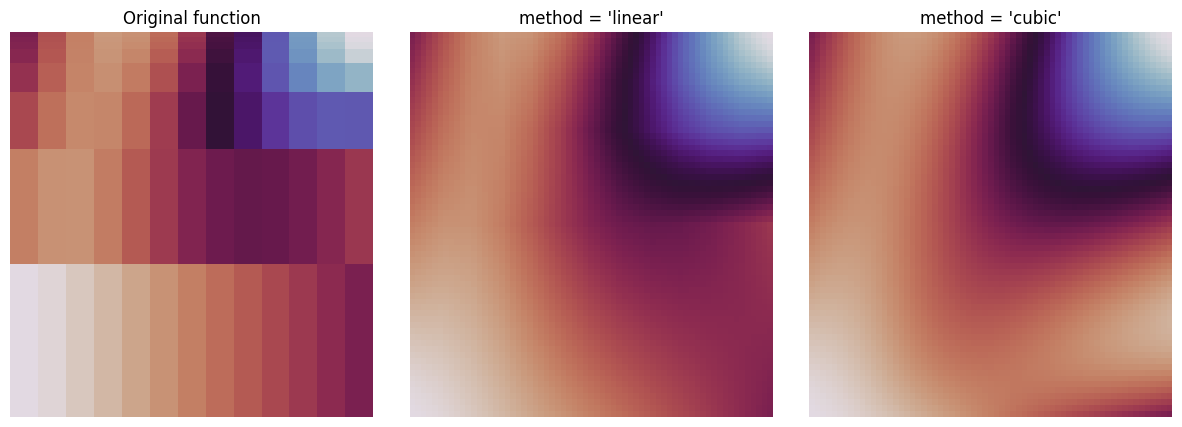

In [13]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

def ff(x, y):
    s = np.hypot(x, y)
    phi = np.arctan2(y, x)
    tau = s + s*(1-s)/5 * np.sin(6*phi) 
    return 5*(1-tau) + tau

x = np.linspace(0, 4, 13)
y = np.array([0, 2, 3, 3.5, 3.75, 3.875, 3.9375, 4])
X, Y = np.meshgrid(x, y)
Z = ff(X,Y)


x2 = np.linspace(0, 4, 65)
y2 = np.linspace(0, 4, 65)
X2, Y2 = np.meshgrid(x2, y2)
points = np.array([X2.flatten(), Y2.flatten()]).T

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].pcolormesh(X, Y, Z,cmap='twilight')
ax[0].set_title("Original function")
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_frame_on(False)


for i, method in enumerate(('linear', 'cubic')):
    interp = RegularGridInterpolator((x, y), Z.T, method=method)
    Zi = interp(points).reshape(65, 65)
    r, c = (i+1) , (i+1) % 2
    ax[r].pcolormesh(X2, Y2, Zi,cmap='twilight')
    ax[r].set_title("method = '{}'".format(method))
    ax[r].set_yticks([])
    ax[r].set_xticks([])
    ax[r].set_frame_on(False)
plt.subplots_adjust(hspace=0.4, wspace=0.1) 
plt.show()


In [7]:
np.array(list(zip(X.flatten(),Y.flatten())))

array([[0.        , 0.        ],
       [0.33333333, 0.        ],
       [0.66666667, 0.        ],
       [1.        , 0.        ],
       [1.33333333, 0.        ],
       [1.66666667, 0.        ],
       [2.        , 0.        ],
       [2.33333333, 0.        ],
       [2.66666667, 0.        ],
       [3.        , 0.        ],
       [3.33333333, 0.        ],
       [3.66666667, 0.        ],
       [4.        , 0.        ],
       [0.        , 2.        ],
       [0.33333333, 2.        ],
       [0.66666667, 2.        ],
       [1.        , 2.        ],
       [1.33333333, 2.        ],
       [1.66666667, 2.        ],
       [2.        , 2.        ],
       [2.33333333, 2.        ],
       [2.66666667, 2.        ],
       [3.        , 2.        ],
       [3.33333333, 2.        ],
       [3.66666667, 2.        ],
       [4.        , 2.        ],
       [0.        , 3.        ],
       [0.33333333, 3.        ],
       [0.66666667, 3.        ],
       [1.        , 3.        ],
       [1.

In [6]:
coordinates

array([[0.        , 0.        ],
       [0.33333333, 0.        ],
       [0.66666667, 0.        ],
       [1.        , 0.        ],
       [1.33333333, 0.        ],
       [1.66666667, 0.        ],
       [2.        , 0.        ],
       [2.33333333, 0.        ],
       [2.66666667, 0.        ],
       [3.        , 0.        ],
       [3.33333333, 0.        ],
       [3.66666667, 0.        ],
       [4.        , 0.        ],
       [0.        , 2.        ],
       [0.33333333, 2.        ],
       [0.66666667, 2.        ],
       [1.        , 2.        ],
       [1.33333333, 2.        ],
       [1.66666667, 2.        ],
       [2.        , 2.        ],
       [2.33333333, 2.        ],
       [2.66666667, 2.        ],
       [3.        , 2.        ],
       [3.33333333, 2.        ],
       [3.66666667, 2.        ],
       [4.        , 2.        ],
       [0.        , 3.        ],
       [0.33333333, 3.        ],
       [0.66666667, 3.        ],
       [1.        , 3.        ],
       [1.